**Modi Omkar<br>
19EE30018**

In [2]:
pip install pytorch-msssim

Note: you may need to restart the kernel to use updated packages.


In [3]:
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as T
from torchvision.transforms import ToTensor
from torchvision import datasets
from torch.autograd import Variable
import torch
import torch.nn as nn
import os
from torchvision.utils import make_grid
from torchvision.utils import save_image
from torchvision.io import read_image
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

#import time
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns

In [4]:
training_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:174.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


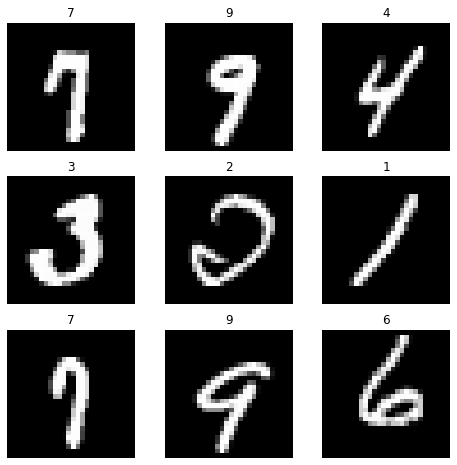

In [5]:
labels_map = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [6]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
# test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [7]:
#Encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.flatten = nn.Flatten()
        self.lin1 = nn.Linear(28*28,1000)
        self.lin2 = nn.Linear(1000, 2)
        self.relu = nn.ReLU()
    def forward(self, x):
        
        inp = self.flatten(x)
        hid = self.lin1(inp)
        hid = self.relu(hid)
        out = self.lin2(hid)
        
        return out

In [8]:
#Decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.lin1 = nn.Linear(2,1000)
        self.lin2 = nn.Linear(1000, 28*28)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        
        hid = self.lin1(x)
        hid = self.relu(hid)
        out = self.lin2(hid)
        out = self.sigmoid(out)
        
        return out

In [9]:
#Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.lin1 = nn.Linear(2,500)
        self.lin2 = nn.Linear(500, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        
        hid = self.lin1(x)
        hid = self.relu(hid)
        out = self.lin2(hid)
        out = self.sigmoid(out)
        
        return out

In [10]:
enc , dec = Encoder(),Decoder()    # Encoder/Decoder
disc = Discriminator()             # Discriminator adversarial
if torch.cuda.is_available():
    enc = enc.cuda()
    dec = dec.cuda()
    disc = disc.cuda()
    
# Set learning rates
gen_lr, reg_lr = 0.0001, 0.00005

# Set optimizators
enc_opt = torch.optim.Adam(enc.parameters(), lr=gen_lr)
dec_opt = torch.optim.Adam(dec.parameters(), lr=gen_lr)
disc_opt = torch.optim.Adam(disc.parameters(), lr=reg_lr)


In [11]:
def BCE(input_x,target):
    loss = nn.functional.binary_cross_entropy(input_x,target)
    
    return loss


In [12]:
def MSE(input_x,target):
    loss = nn.functional.mse_loss(input_x, target)

    return loss

In [13]:
def SSIM(input_x,target):
    X = torch.reshape(input_x,(input_x.shape[0],1,28,28))
    y = torch.reshape(target,(target.shape[0],1,28,28))
    ssim_loss = 1 - ssim(X, y, data_range=1, size_average=True)
    
    
    return ssim_loss

In [14]:
X = next(iter(train_dataloader))[0]
print(X.shape[2]*X.shape[3])

784


In [15]:
def report_loss(epoch, Discriminator_loss, Generator_loss, recon_loss):
    '''
    Print loss
    '''
    print('Epoch-{}; Discriminator_loss: {:.4}; Generator_loss: {:.4}; recon_loss: {:.4}'.format(epoch,
                                                                                   Discriminator_loss,
                                                                                   Generator_loss,
                                                                                   recon_loss))

In [16]:
def train(dec, enc, disc, dec_opt, enc_opt, enc_generator,disc_opt, data_loader,loss):

    # Set the networks in train mode (apply dropout when needed)
    enc.train()
    dec.train()
    disc.train()

    for X, target in data_loader:
        if(X.shape[0]!=64):
            break
        # Load batch and normalize samples to be between 0 and 1
        X_dim = X.shape[2]*X.shape[3]
        train_batch_size = X.shape[0]
        X.resize_(train_batch_size, X_dim)
        X, target = Variable(X), Variable(target)
        if cuda:
            X, target = X.cuda(), target.cuda()

        # Init gradients
        dec.zero_grad()
        enc.zero_grad()
        disc.zero_grad()

        #######################
        # Reconstruction phase
        #######################
        latent_var = enc(X)
        recon_img = dec(latent_var)
        recon_loss = loss(recon_img, torch.reshape(X,(train_batch_size, X_dim)))

        recon_loss.backward()
        dec_opt.step()
        enc_opt.step()

        enc.zero_grad()
        dec.zero_grad()
        disc.zero_grad()

        #######################
        # Regularization phase
        #######################
        # Discriminator
        enc.eval()
        lat_gauss = Variable(torch.randn(train_batch_size, 2) * 5.)
        if cuda:
            lat_gauss = lat_gauss.cuda()

        lat_enc = enc(X)

        D_real_gauss = disc(lat_gauss)
        D_fake_gauss = disc(lat_enc)

        D_loss = -torch.mean(torch.log(D_real_gauss) + torch.log(1 - D_fake_gauss))

        D_loss.backward()
        disc_opt.step()

        enc.zero_grad()
        dec.zero_grad()
        disc.zero_grad()

        # Generator
        enc.train()
        lat_enc = enc(X)

        D_fake_gauss = disc(lat_enc)
        G_loss = -torch.mean(torch.log(D_fake_gauss))

        G_loss.backward()
        enc_generator.step()

        enc.zero_grad()
        dec.zero_grad()
        disc.zero_grad()
        
        #Eval accuracy
        disc.eval()
        pred = disc(enc(X))
        acc = (pred.reshape(-1).detach().cpu().numpy().round() == np.ones(train_batch_size)).mean()
        
    return D_loss, G_loss, recon_loss, acc

In [17]:
def generate_model(train_dataloader,loss):
    
    generator_loss = []
    discriminator_loss = []
    reconstruction_loss = []  
    accuracy = []
    
    torch.manual_seed(10)

    if cuda:
        enc = Encoder().cuda()
        dec = Decoder().cuda()
        disc = Discriminator().cuda()
    else:
        enc = Encoder()
        dec = Decoder()
        disc = Discriminator()

    # Set learning rates
    gen_lr = 0.0001
    reg_lr = 0.00005

    # Set optimizators
    dec_opt = torch.optim.Adam(dec.parameters(), lr=gen_lr)
    enc_opt = torch.optim.Adam(enc.parameters(), lr=gen_lr)

    enc_generator = torch.optim.Adam(enc.parameters(), lr=gen_lr)
    disc_opt = torch.optim.Adam(disc.parameters(), lr=reg_lr)

    for epoch in range(epochs):
        D_loss, G_loss, recon_loss, acc = train(dec, enc, disc, dec_opt, enc_opt, enc_generator,disc_opt, train_dataloader,loss)
        discriminator_loss.append(D_loss.item())
        generator_loss.append(G_loss.item())
        reconstruction_loss.append(recon_loss.item())
        accuracy.append(acc)
        
        if epoch % 10 == 0:
            report_loss(epoch, D_loss.item(), G_loss.item(), recon_loss.item())
        

    return enc, dec, generator_loss, discriminator_loss , reconstruction_loss, accuracy

In [18]:
def print_img(enc,dec):
    figure = plt.figure(figsize=(2, 10))
    cols, rows = 2,10
    for i in range(0,rows):
        labels = training_data.targets.numpy()
        sample_idx = np.random.choice(np.where(labels==i)[0])
        img, label = training_data[sample_idx]
        figure.add_subplot(rows, cols, 2*i+1)
        plt.title("Original")
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
        figure.add_subplot(rows, cols, 2*i+2)
        plt.title("Generated")
        plt.axis("off")
        img1 = torch.unsqueeze(img,0)
        if cuda:
            img1 = img1.to(device='cuda')
        lat_var = enc(img1)
        gen_img = torch.reshape(dec(lat_var),(28,28)).detach().cpu()
        plt.imshow(gen_img, cmap="gray")
    plt.show()

In [19]:
if torch.cuda.is_available():
    cuda = 1
else :
    cuda = 0


epochs = 100

Epoch-0; Discriminator_loss: 1.097; Generator_loss: 0.7577; recon_loss: 0.2613
Epoch-10; Discriminator_loss: 1.411; Generator_loss: 0.6912; recon_loss: 0.219
Epoch-20; Discriminator_loss: 1.386; Generator_loss: 0.6839; recon_loss: 0.2167
Epoch-30; Discriminator_loss: 1.388; Generator_loss: 0.7118; recon_loss: 0.1965
Epoch-40; Discriminator_loss: 1.382; Generator_loss: 0.7066; recon_loss: 0.2036
Epoch-50; Discriminator_loss: 1.39; Generator_loss: 0.6856; recon_loss: 0.2121
Epoch-60; Discriminator_loss: 1.387; Generator_loss: 0.6825; recon_loss: 0.197
Epoch-70; Discriminator_loss: 1.397; Generator_loss: 0.6902; recon_loss: 0.191
Epoch-80; Discriminator_loss: 1.387; Generator_loss: 0.6917; recon_loss: 0.2052
Epoch-90; Discriminator_loss: 1.386; Generator_loss: 0.6936; recon_loss: 0.1966


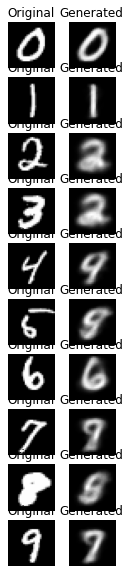

In [20]:
enc_bce, dec_bce, g_l_bce, d_l_bce, r_l_bce, acc_l_bce  = generate_model(train_dataloader,BCE)
print_img(enc_bce,dec_bce)

Epoch-0; Discriminator_loss: 1.127; Generator_loss: 0.7041; recon_loss: 0.0654
Epoch-10; Discriminator_loss: 1.402; Generator_loss: 0.714; recon_loss: 0.05032
Epoch-20; Discriminator_loss: 1.388; Generator_loss: 0.6815; recon_loss: 0.04975
Epoch-30; Discriminator_loss: 1.389; Generator_loss: 0.693; recon_loss: 0.04531
Epoch-40; Discriminator_loss: 1.375; Generator_loss: 0.7005; recon_loss: 0.04761
Epoch-50; Discriminator_loss: 1.391; Generator_loss: 0.6786; recon_loss: 0.05149
Epoch-60; Discriminator_loss: 1.385; Generator_loss: 0.6797; recon_loss: 0.04405
Epoch-70; Discriminator_loss: 1.401; Generator_loss: 0.6746; recon_loss: 0.0433
Epoch-80; Discriminator_loss: 1.394; Generator_loss: 0.6933; recon_loss: 0.04718
Epoch-90; Discriminator_loss: 1.387; Generator_loss: 0.6799; recon_loss: 0.04578


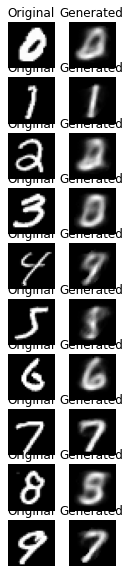

In [21]:
enc_mse, dec_mse, g_l_mse, d_l_mse, r_l_mse, acc_l_mse  = generate_model(train_dataloader,MSE)
print_img(enc_mse,dec_mse)

Epoch-0; Discriminator_loss: 1.314; Generator_loss: 0.6059; recon_loss: 0.73
Epoch-10; Discriminator_loss: 1.39; Generator_loss: 0.7086; recon_loss: 0.562
Epoch-20; Discriminator_loss: 1.386; Generator_loss: 0.6928; recon_loss: 0.5507
Epoch-30; Discriminator_loss: 1.387; Generator_loss: 0.7058; recon_loss: 0.5114
Epoch-40; Discriminator_loss: 1.399; Generator_loss: 0.7086; recon_loss: 0.5338
Epoch-50; Discriminator_loss: 1.393; Generator_loss: 0.6736; recon_loss: 0.5647
Epoch-60; Discriminator_loss: 1.391; Generator_loss: 0.6755; recon_loss: 0.498
Epoch-70; Discriminator_loss: 1.388; Generator_loss: 0.6847; recon_loss: 0.4918
Epoch-80; Discriminator_loss: 1.388; Generator_loss: 0.695; recon_loss: 0.5141
Epoch-90; Discriminator_loss: 1.384; Generator_loss: 0.6838; recon_loss: 0.4976


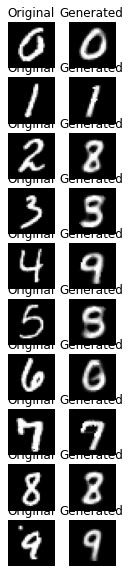

In [22]:
enc_ssim, dec_ssim, g_l_ssim, d_l_ssim, r_l_ssim, acc_l_ssim  = generate_model(train_dataloader,SSIM)
print_img(enc_ssim,dec_ssim)

In [23]:
def plot_loss(disc_loss,rec_loss,title):
    e = [e_ for e_ in range(epochs)]
    plt.title(title)
    plt.plot(e, disc_loss, '-', label='discriminator_loss')
    plt.plot(e, rec_loss, '-', label='recon_loss')
    plt.legend(loc='best')
    plt.show()

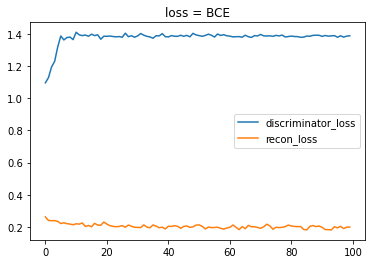

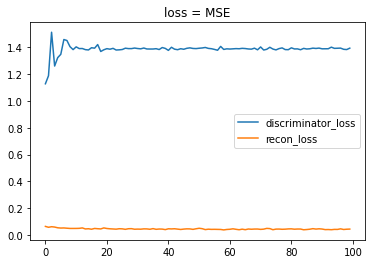

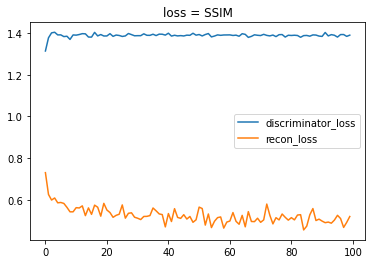

In [24]:
#Q2)

plot_loss(d_l_bce,r_l_bce,'loss = BCE')
plot_loss(d_l_mse,r_l_mse,'loss = MSE')
plot_loss(d_l_ssim,r_l_ssim,'loss = SSIM')

Discrimator loss increases initially and almost remain constant whereas reconstruction loss decress with epoch. Weigths of encoder and decoder are so as trained such that decoder tries to output the same input image taking output of encoder so as model trains reconstruction loss decreases. Discriminator tries to discriminate the output encoder generates and random gaussian sample as the encoder learns to generate samples like gaussian distribution discriminator fails to identify real and fake input so loss of discriminator remains almost constant.

**Q3)**
### &emsp; auto_encoder learning phase
* Encoder takes the image as an input and through dense network with one hidden network having 1000 neurons in our case generates a latent variable of out size 2.
* This latent variable is generated by encoder is feed into decoder which upscales the image again to original size and tries to learn its weights so as to create the original input image
* The problem here is output generated by encoder is not bounded and fix and in some cases in generating mode the decoder gets input from encoder which it has never seen before which causes output of decoder to be random so to avoid this we train are encoder weigths such that the output follow certain distribution
### discriminator learning phase/  regularization phase
* The Discriminator is feed with real gaussian sample and output of discriminator is set to 1 and output of encoderare feed to discriminator keeping target to 0 so that discriminator learns to classify real and fake input of gaussian distribution
### *generation phase*
* Weigths of encoder are trained such that discriminator identifies it to be true thus encoder learns to output in given distribution
* latent variable produced by encoder is feed to decoder to generate image

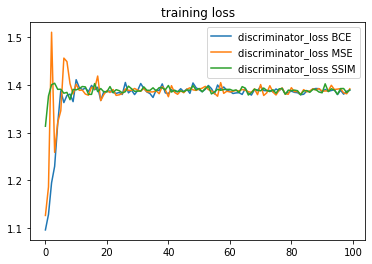

In [25]:
e = [e_ for e_ in range(epochs)]
plt.title("training loss")
plt.plot(e, d_l_bce, '-', label='discriminator_loss BCE')
plt.plot(e, d_l_mse, '-', label='discriminator_loss MSE')
plt.plot(e, d_l_ssim, '-', label='discriminator_loss SSIM')
plt.legend(loc='best')
plt.show()

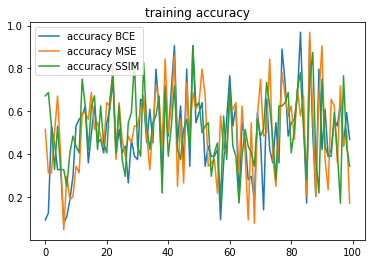

In [26]:
e = [e_ for e_ in range(epochs)]
plt.title("training accuracy")
plt.plot(e, acc_l_bce, '-', label='accuracy BCE')
plt.plot(e, acc_l_mse, '-', label='accuracy MSE')
plt.plot(e, acc_l_ssim, '-', label='accuracy SSIM')
plt.legend(loc='best')
plt.show()

**Q5)**
from the loss plot of all the three losses perform equally but BCE in intial training epoch showed better performance, In middle and ending stage of training loss is almost same and constant for all 3 loses. Also from accuracy plot BCE has highest accuracy out of all other Losses so BCE is favourable
